#### Experiment filtering up and down methods

Might have to experiment with invr file 

First create a custom dataframe to experiment

In [22]:
# import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import shapely.geometry as geom

In [23]:
# Create a DataFrame with box names and values
box_names = [chr(65 + i) for i in range(16)]
index = list(range(0, 16))
values = list(range(1, 17))

In [24]:
df = pd.DataFrame({'FIPS': box_names,'Index': index, 'Value': values})

In [25]:
df.head()

,FIPS,Index,Value
0,A,0,1
1,B,1,2
2,C,2,3
3,D,3,4
4,E,4,5


In [26]:
# Sorting the DataFrame based on the 'rate' column :::: Values are needed to be sorted in ascending order
df.sort_values(by='Value', inplace=True)

# Adding a new column 'new_ID' with ID values starting from zero
df['sortedID'] = range(len(df))

In [27]:
df.head()

,FIPS,Index,Value,sortedID
0,A,0,1,0
1,B,1,2,1
2,C,2,3,2
3,D,3,4,3
4,E,4,5,4


In [28]:
# Function to calculate square coordinates for a given name
def calculate_square_coordinates(row):
    value = row['Index']
    # Assuming each smaller square has a side length of 1 unit
    x = value % 4
    y = value // 4
    # Return square coordinates as a Shapely polygon
    return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])

In [29]:
# Calculate square coordinates for each row and create a geometry column
df['geometry'] = df.apply(calculate_square_coordinates, axis=1)

In [30]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Set the CRS to a simple Cartesian coordinate system
gdf.crs = "EPSG:3395"  # This is a commonly used projected CRS

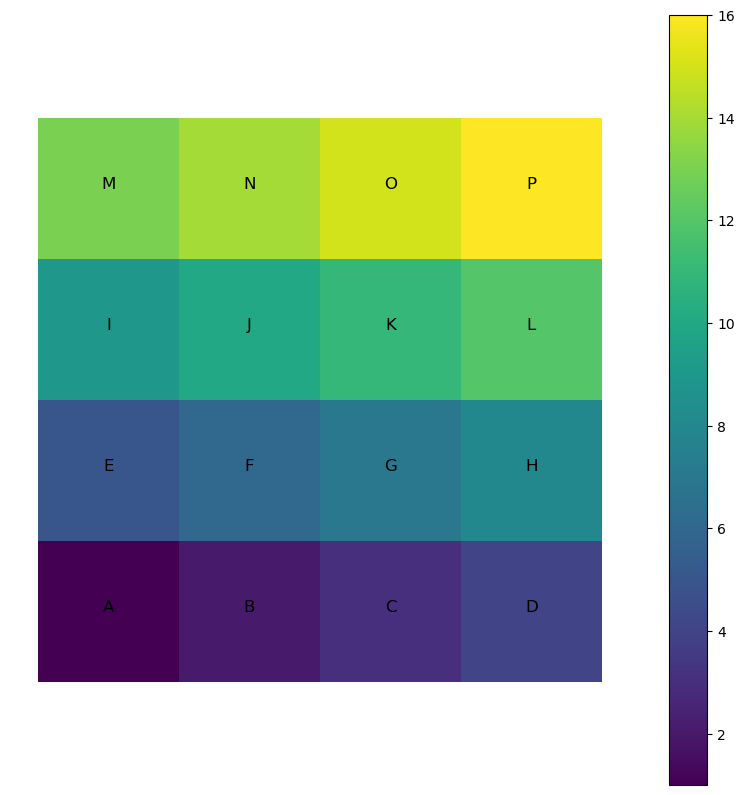

In [34]:
# plot the geodataframe

fig, ax = plt.subplots(figsize=(5, 5))
gdf.plot(ax=ax, column='Value', cmap='viridis', legend=True)
for x, y, label in zip(gdf.geometry.centroid.x, gdf.geometry.centroid.y, gdf['FIPS']):
    ax.text(x, y, label, fontsize=12, ha='center')
plt.axis('off')
plt.show()